In [1]:
from subpred.graph import (
    preprocess_data,
    get_substrate_matrix,
    create_heatmap,
    get_graph_plot,
)
import pandas as pd


In [2]:
organism_names = ["athaliana"]  # "ecoli", "yeast", "human",

In [3]:
organism_name_to_id = {
    "ecoli": 83333,
    "yeast": 559292,
    "human": 9606,
    "athaliana": 3702,
}
organism_ids = {organism_name_to_id[organism_name] for organism_name in organism_names}
dataset_name = "+".join(sorted(organism_names))

datasets_folder_path = "../data/datasets"
heatmap_output_path = f"../reports/01_labels_organisms/heatmap_{dataset_name}.png"
graph_output_path = f"../reports/01_labels_organisms/graph_{dataset_name}.png"
heatmap_title = f"Substrate molecular species overlaps for substrates with 20 or more transport proteins in dataset {dataset_name}"
graph_title = f"Relations between molecular species in for substrates with 20 or more transport proteins, only including abstractions\
      and tautomers, in dataset {dataset_name}"

Read datasets:

- Uniprot
- Uniprot GOA
- Ontologies
    - Chebi
    - GO

In [4]:
df_uniprot, df_uniprot_goa, graph_go, graph_chebi = preprocess_data(
    organism_ids=organism_ids,
    datasets_folder_path=datasets_folder_path,
)

## Substrate matrix 

In [5]:
df_substrate_overlaps_full, dict_chebi_to_uniprot_full = get_substrate_matrix(
    datasets_folder_path=datasets_folder_path,
    graph_chebi=graph_chebi,
    graph_go=graph_go,
    df_uniprot_goa=df_uniprot_goa,
    min_overlap=20,
    max_overlap=1000000,
    include_ancestor_chebi_ids=True,
)

### Labels

In [6]:

chebi_id_to_name = {node: name for node, name in graph_chebi.nodes(data="name")}
df_chebi_to_uniprot = pd.DataFrame(
    dict_chebi_to_uniprot_full.items(), columns=["chebi_id", "Uniprot"]
)

df_chebi_to_uniprot["chebi_term"] = df_chebi_to_uniprot.chebi_id.map(chebi_id_to_name)

df_chebi_to_uniprot = df_chebi_to_uniprot.explode("Uniprot").reset_index(drop=True)

df_chebi_to_uniprot = (
    df_chebi_to_uniprot[["Uniprot", "chebi_id", "chebi_term"]]
    .sort_values(["Uniprot", "chebi_id"])
    .reset_index(drop=True)
)

In [7]:
df_chebi_to_uniprot[
    df_chebi_to_uniprot.chebi_term == "calcium(2+)"
].Uniprot.unique().shape[0]

44

In [8]:
chebi_term_protein_count = (
    df_chebi_to_uniprot[["Uniprot", "chebi_term"]]
    .groupby("chebi_term")
    .apply(len)
    .sort_values(ascending=False)
)
chebi_term_protein_count[
    (chebi_term_protein_count >= 20) & (chebi_term_protein_count < 200)
]

chebi_term
metal cation                 138
proton                       125
organic anion                 82
carbohydrate                  71
inorganic anion               70
carboxylic acid anion         58
organic acid                  58
potassium(1+)                 56
carbohydrate derivative       53
monoatomic anion              46
biomacromolecule              45
calcium(2+)                   44
transition element cation     33
amino acid                    32
amide                         30
organophosphorus compound     27
organic phosphate             27
sulfur molecular entity       22
water                         22
monosaccharide                22
dtype: int64

## Heatmap

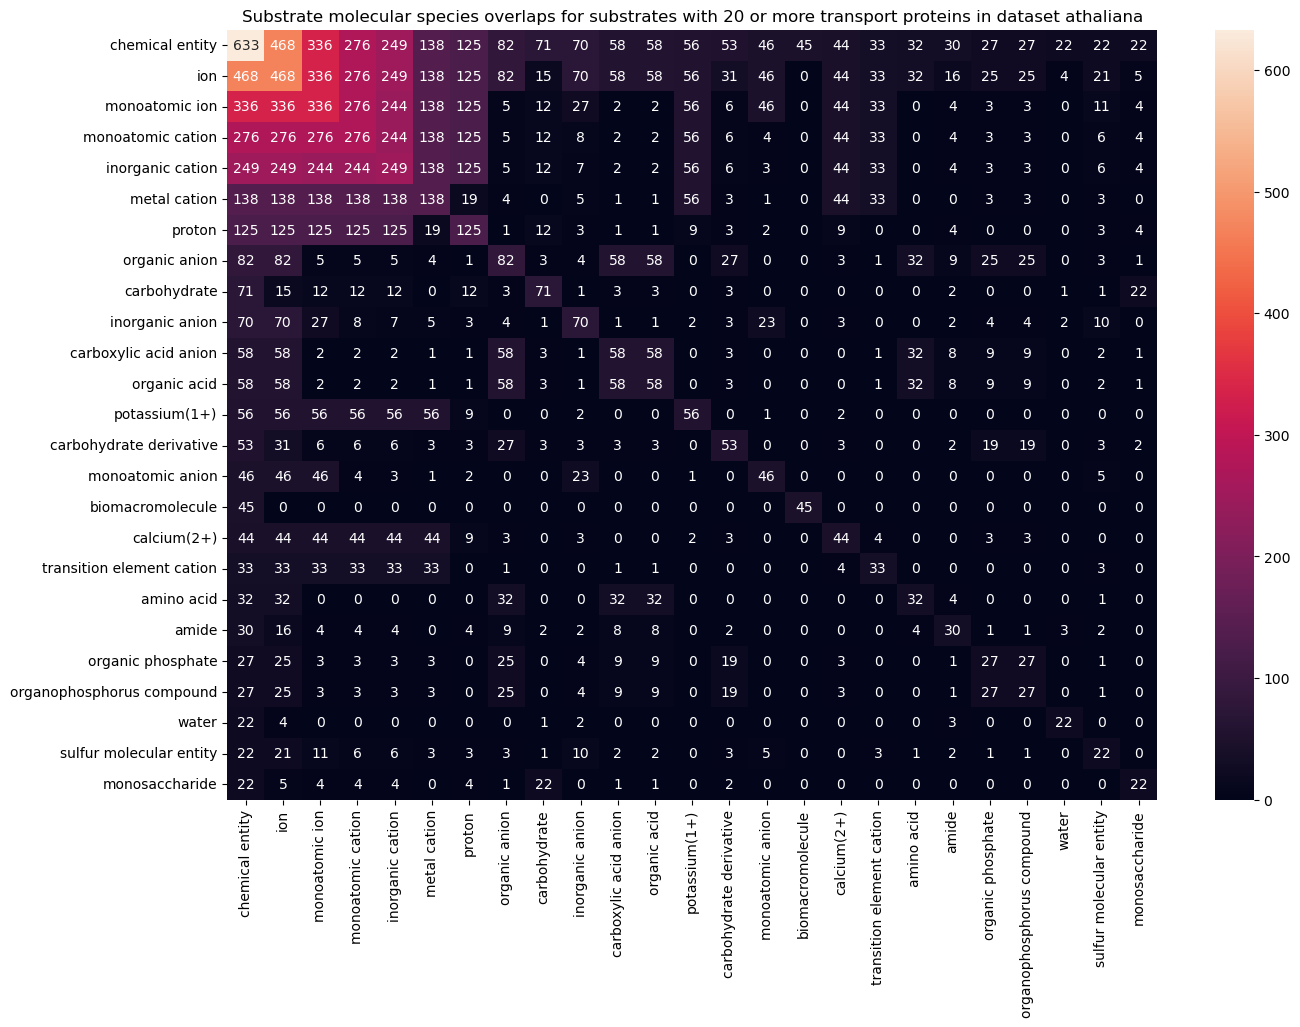

In [9]:
g = create_heatmap(
    df_matrix=df_substrate_overlaps_full,
    title=heatmap_title,
    width=15,
    height=10,
    lower_triangle_only=False,
    output_path=heatmap_output_path,
)
# from matplotlib import pyplot as plt
# g.figure.savefig("test.png",  bbox_inches='tight')


## Network

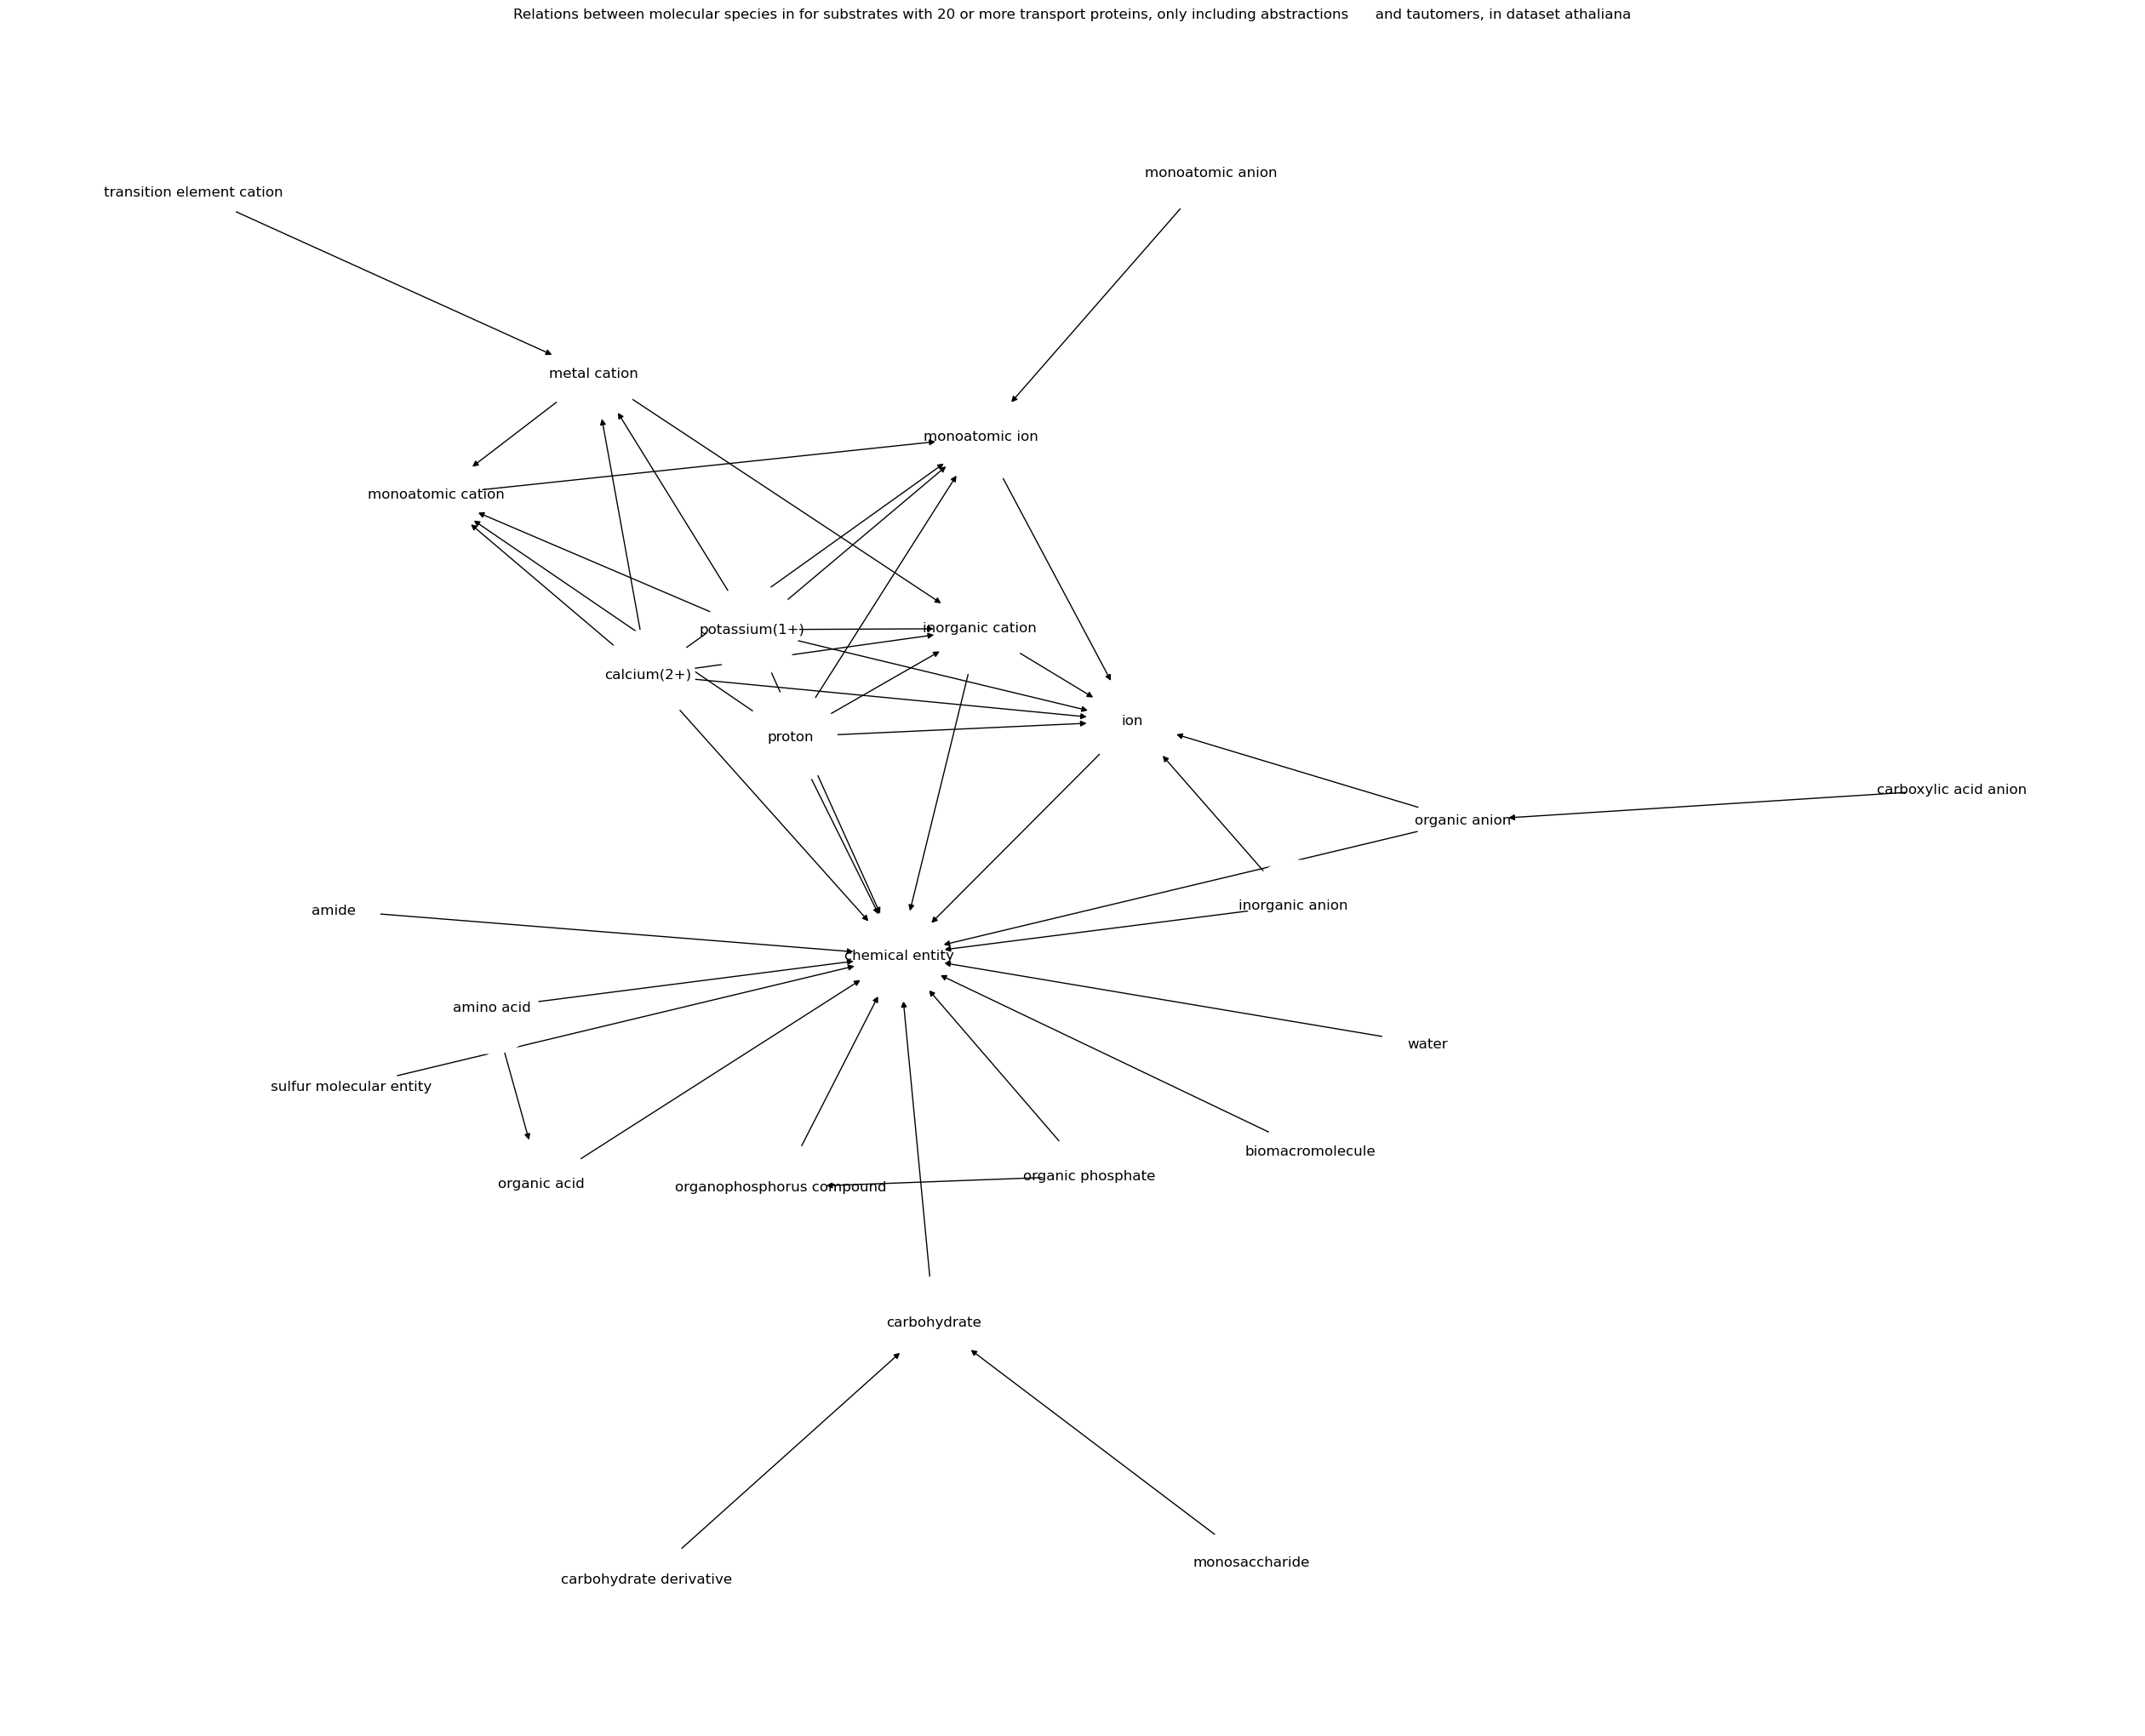

In [10]:
graph_chebi_heatmap, _ = get_graph_plot(
    df_substrate_overlaps=df_substrate_overlaps_full,
    dict_chebi_to_uniprot=dict_chebi_to_uniprot_full,
    graph_chebi=graph_chebi,
    graph_output_path=graph_output_path,
    title=graph_title,
    node_size=6000,
    width=25,
    height=20,
)

### Why is there an overlap between amino acid and ion?

The reason was that the GO term **carboxylic acid transmembrane transporter activity** is defined as:

*Enables the transfer of carboxylic acids from one side of a membrane to the other. Carboxylic acids are organic acids containing one or more carboxyl (COOH) groups or anions (COO-).*

Amino acids are considered anions when they occur in basic conditions, and cations when occurring in acidic conditions. In solution, amino acids occur as zwitterions. 



Additionally, we found that the GO term that is annotated with "Ion" is not "Ion transmembrane transporter activity", but "P-type transmembrane transporter activity", which is a form of active transport that uses the ATP-ADP reaction. This term describes the mechanism, which is active transport, not a *substrate* transport. In fact, a go term called *ion transmembrane transporter activity* does not exist, only monoatomic ion and cation or anion.

One idea to solve this problem would be to exclude active and passive transport descendants from the list of relevant GO terms.


